In [ ]:
# API Token 다운받기
# 다운받은 API Token 업로드 하기
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"whitebean","key":"bf8841bcf7683c2426c7f904d0f84200"}'}

In [ ]:
# json 파일 제대로 업로드 됐는지 확인
!ls -1ha kaggle.json

kaggle.json


In [ ]:
# json 파일 옮겨주기
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

In [ ]:
!kaggle competitions download -c dogs-vs-cats

 98% 533M/543M [00:08<00:00, 62.6MB/s]
100% 543M/543M [00:09<00:00, 63.2MB/s]
 96% 261M/271M [00:03<00:00, 129MB/s]
100% 271M/271M [00:03<00:00, 75.7MB/s]
  0% 0.00/86.8k [00:00<?, ?B/s]
100% 86.8k/86.8k [00:00<00:00, 83.2MB/s]


In [ ]:
!ls

kaggle.json  sample_data  sampleSubmission.csv	test1.zip  train.zip


In [ ]:
!unzip test1.zip

In [ ]:
!unzip train.zip

In [ ]:
!pwd

/content


# **캐글 Competition**
# **고양이와 개 분류하기**
https://www.kaggle.com/c/dogs-vs-cats

#### warning 출력 off

In [ ]:
# warning 뜨지 않게 하기
import warnings
warnings.filterwarnings('ignore')

#### 필요한 패키지 import

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [ ]:
print(os.listdir("sample_data"))

['anscombe.json', 'README.md', 'california_housing_test.csv', 'mnist_train_small.csv', 'california_housing_train.csv', 'mnist_test.csv']


#### 글로벌 변수 선언

In [ ]:
FAST_RUN = False
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3   # convolution 연산 시 사용할 channel 정보

#### 파일명과 정답 설정

In [ ]:
# Preparing Traning Data
# 개인 경우 ('개', 1)
# 고양이인 경우 ('고양이', 0) 으로 저장

filenames = os.listdir("train")
categories=[]
for filename in filenames:
    category = filename.split('.')[0]     # . 으로 분리하고 그 중 첫번째 부분, 즉 dog, cat 부분
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename':filenames,
    'category':categories
})

#### 저장 잘 되었는지 확인

In [ ]:
df.head()

,filename,category
0,cat.2768.jpg,0
1,cat.2540.jpg,0
2,cat.9790.jpg,0
3,dog.8345.jpg,1
4,cat.730.jpg,0


In [ ]:
df.tail()

,filename,category
24995,cat.231.jpg,0
24996,dog.3010.jpg,1
24997,cat.9971.jpg,0
24998,cat.9852.jpg,0
24999,cat.4000.jpg,0


#### 데이터 분포 확인

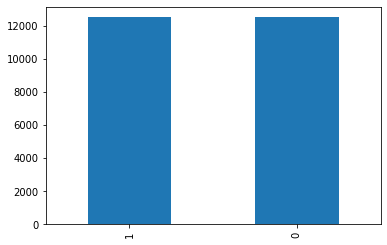

In [ ]:
# category별 데이터가 균일하게 분포되어 있는지 확인
df['category'].value_counts().plot.bar()    # category별 변수 갯수 세서 막대그래프로

#### Sample 데이터 확인

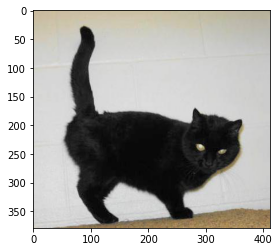

In [ ]:
sample = random.choice(filenames)   # filenames 중 랜덤 선택
image = load_img("train/"+sample)
plt.imshow(image)

#### 신경망 모델 구성

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

# 입력값 → 필터 → 결과값
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))   # 126X126, 32개
model.add(BatchNormalization())
# Dimention 축소
model.add(MaxPooling2D(pool_size=(2, 2)))   # 63X63, 32개
# overfitting 방지
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))  # 61X61, 64개
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))   #  30X30, 64개
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))   # 28X28, 128개
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))   # 14X14, 128개
model.add(Dropout(0.25))

model.add(Flatten())    # 14X14X128 = 25088
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))  # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

#### 콜백 정의

In [ ]:
# 조기종료와 학습율 하향조정
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# To prevent overfitting we will stop the learning after 10 epochs and val_loss value not decreased
earlystop = EarlyStopping(patience=10)

In [ ]:
# We will reduce the learning rate when then accuracy not increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                           patience=2,
                                           verbose=1,
                                           factor=0.5,
                                           min_lr=0.00001)

#### 콜백 설정

In [ ]:
callbacks = [earlystop, learning_rate_reduction]

#### 개, 고양이를 string으로 변환

In [ ]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [ ]:
df.head()

,filename,category
0,cat.2768.jpg,cat
1,cat.2540.jpg,cat
2,cat.9790.jpg,cat
3,dog.8345.jpg,dog
4,cat.730.jpg,cat


#### train-validation 데이터 분리

In [ ]:
# train 데이터 중 20%를 학습중 파라미터 검증을 위한 validation 셋으로
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validation_df = validate_df.reset_index(drop=True)

#### train 데이터 분포 확인

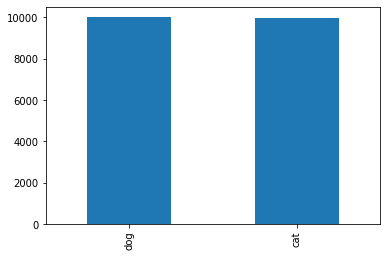

In [ ]:
train_df['category'].value_counts().plot.bar()

#### validation 분포 확인

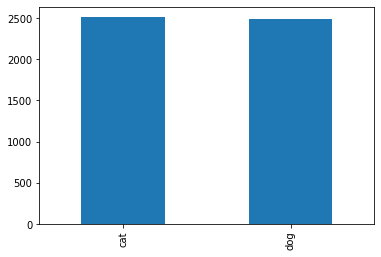

In [ ]:
validate_df['category'].value_counts().plot.bar()

#### 학습, 검증데이터 확인

In [ ]:
# 학습, 검증 데이터 형상 확인 및 batch size 설정
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size = 15

#### Train Data augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


#### Validation Data augmentation

In [ ]:
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


#### 샘플 확인

In [ ]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


#### 이미지 확인

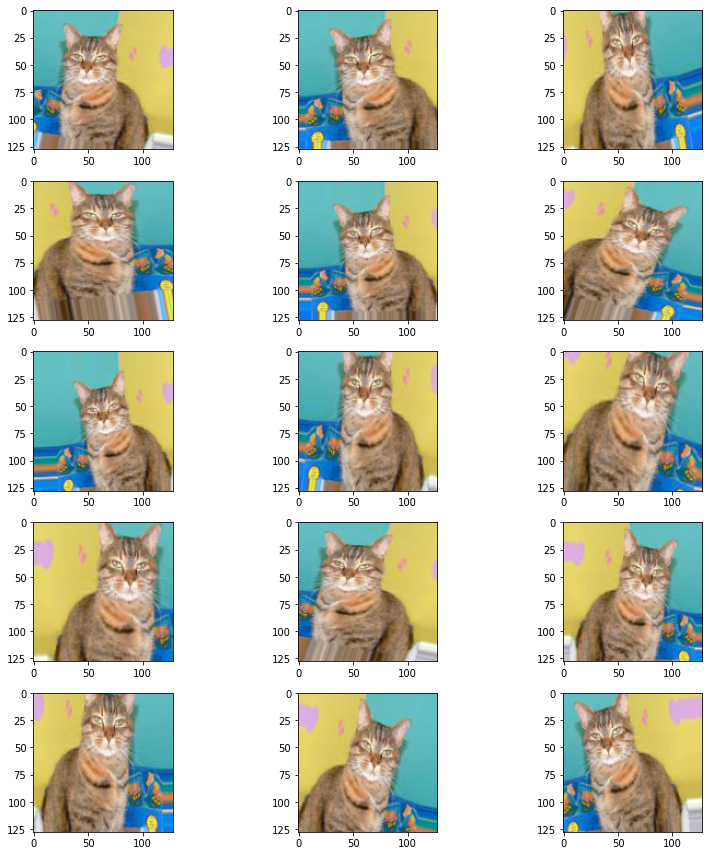

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

#### 학습시작

In [ ]:
epochs = 3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = total_validate//batch_size,
    steps_per_epoch = total_train//batch_size,
    callbacks = callbacks
)

#### 모델 저장

model.save_weights("model.h5")

#### 학습 내용 확인

In [ ]:
# 시각화
fig. (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_loss'], color='r', label="validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

#### Test

In [ ]:
test_filenames = os.listdir("./data/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

#### 평가 데이터 준비

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df,
    "./data/test/",
    x_col='filename',
    y_col=None,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=batch_size
)

#### 모델 예측

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

#### 평가 생성

In [ ]:
# prediction 결과는 각 record별, 개일확률, 고양이일 확률 담겨져 있음
# 편의성, 정확도 검증 위해 개와 고양이일 확률중 큰 값에 해당하는 레이블 선택해 치환
test_df['category'] = np.argmax(predict, axis=-1)

#### 레이블 변환

In [ ]:
test_df['category'] = test_df['category'].replace({'dog':1, 'cat':0})

#### 정답비율 확인

In [ ]:
test_df['category'].value_counts().plot.bar()

#### 정답 확인

In [ ]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./data/test/"+filename, target_size = IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename+'('+"{}".format(category)+')')
plt.tight_layout()
plt.show()